In [1]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_style('whitegrid')

sys.path.append("../")
from utility.ar1 import AR1
from utility.ar import AR

### Posterior Samples

<AxesSubplot: >

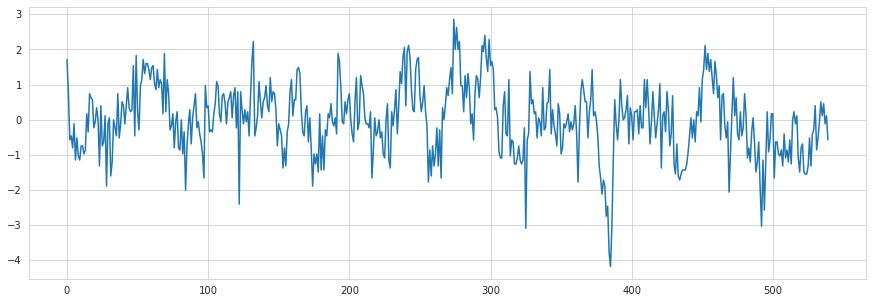

In [2]:
soi = pd.read_table("../data/soi.txt", names=['soi']).soi
soi.plot(figsize=(15, 5))

In [265]:
# find the conditional AR(1) parameters
ar1 = AR(lags=1)
ar1.fit(soi.iloc[60:80].values)

v_sample = ar1.sample_innovation_var(10000)
b_sample = ar1.sample_coeff(v_sample)
logps = ar1.log_likelihood(b_sample, v_sample)
logps = pd.DataFrame(logps, columns=['logp','logg', 'iw'])

/home/ztang484/workplace/duke/sta831-sp23/ch3/../utility/ar.py:140: RuntimeWarning: invalid value encountered in log
  logp = np.log(a)/2 - ((n+1)/2)*np.log(v) - Qp/(2*v)


### Sample Checks

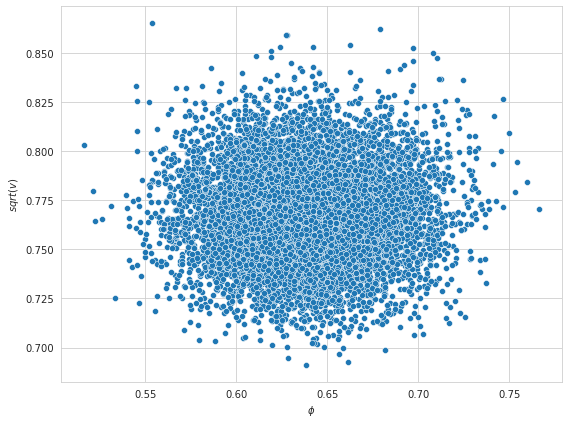

In [132]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x=b_sample.ravel(), y=np.sqrt(v_sample), ax=ax)

ax.set_ylabel('$sqrt(v)$')
ax.set_xlabel('$\phi$')
fig.tight_layout()
fig.show()

/tmp/ipykernel_17053/2461510958.py:3: RuntimeWarning: invalid value encountered in log
  sns.histplot(-np.log(2)/np.log(b_sample.ravel()), ax=ax[1])


count    10000.000000
mean         0.423301
std          0.240367
min         -0.561068
25%          0.268325
50%          0.423616
75%          0.579236
max          1.519016
dtype: float64


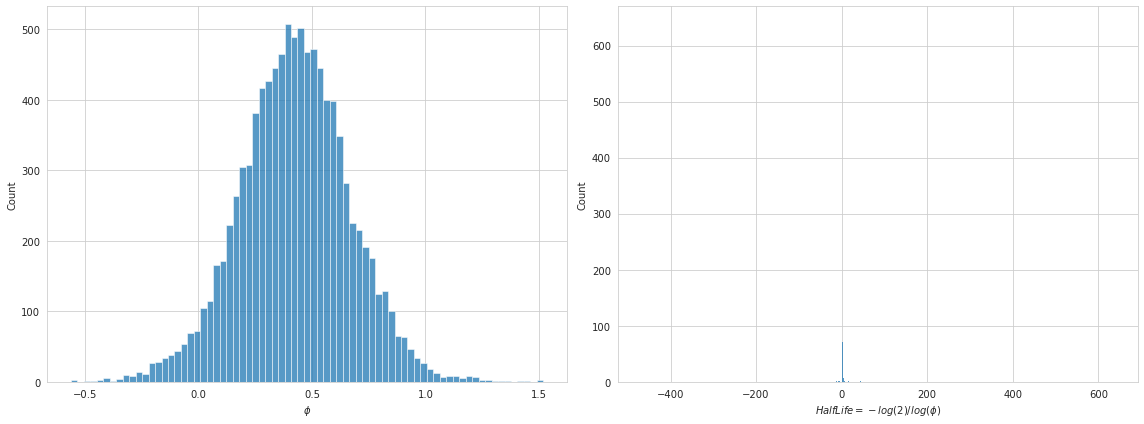

In [150]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.histplot(b_sample.ravel(), ax=ax[0])
sns.histplot(-np.log(2)/np.log(b_sample.ravel()), ax=ax[1])

ax[0].set_xlabel("$\\phi$")
ax[1].set_xlabel("$Half Life = -log(2)/log(\\phi)$")
fig.tight_layout()
fig.show()

print(pd.Series(b_sample.ravel()).describe())

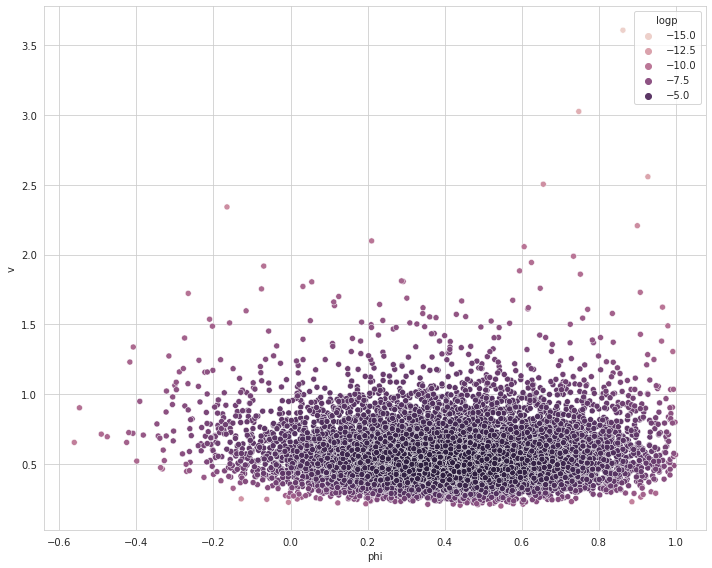

In [149]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    data=pd.DataFrame(np.c_[b_sample[:,0], v_sample, logps.logp], columns=['phi','v','logp']),
    x='phi', y='v', hue='logp', ax=ax
)
fig.tight_layout()
fig.show()

### Resampling using the importance weight approximation

All posterior samples are generated fron the conditional normal-inverse-wishart conjugate $p(x[1:n]|θ, x[0])$.
However, it is off for a bit from the full posterior $p(x[0:n]|θ)$. We can treat treat the conditional posterior $g(θ) = p(x[1:n]|θ, x[0])$ as the proposal distribution in the importance sampler. Because it is much easier to sample from. Then, we treat the full posterior $p(θ) = p(x[0:n]|θ)$ the target distribution. Since we can evaluate the unnormalized density for any $θ$, we can calcualte the importance weights $w(θ)$ then resample the posterior samples to arrive at the full posterior samples.

<AxesSubplot: xlabel='logp', ylabel='logg'>

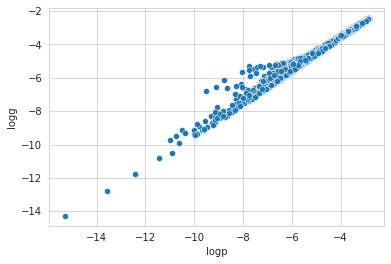

In [266]:
sns.scatterplot(data=logps, x='logp', y='logg')

In [267]:
# ESS
1/(logps.iw**2).sum() / 10000

0.979803696458553

In [268]:
# Comparison between conditional and full stationary
print(b_sample[:,0].mean(), (logps.iw * b_sample[:,0]).sum())
print(v_sample.mean(), (logps.iw * v_sample).sum())

0.4239499726767026 0.41288569575711165
0.5585996908160269 0.558109732647698


In [269]:
weights = logps.iw
phis = b_sample[:, 0][~weights.isna()]
vs = v_sample[~weights.isna()]
weights = weights[~weights.isna()]

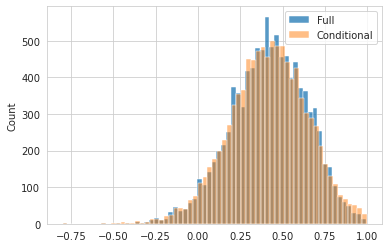

In [270]:
sns.histplot(np.random.choice(phis, size=10000, p=weights), label='Full')
sns.histplot(phis, label='Conditional', alpha=0.5)
plt.legend()

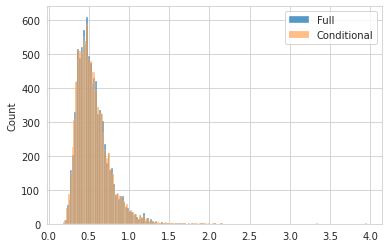

In [271]:
sns.histplot(np.random.choice(vs, size=10000, p=weights), label='Full')
sns.histplot(vs, label='Conditional', alpha=0.5)
plt.legend()